In [13]:
import pysam
import deepchopper
from deepchopper import (
    remove_intervals_and_keep_left,
)
from deepchopper.utils import highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import logging
from rich.logging import RichHandler
from needletail import (
    parse_fastx_file,
    NeedletailError,
)

import seaborn as sns
import re
from textwrap import wrap
import gget

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.WARN,
    format=FORMAT,
    handlers=[RichHandler()],
)

INTERNAL_THRESHOLD: float = 0.9
OVERLAP_THRESHOLD: float = 0.4
BLAT_THRESHOLD: float = 0.9
MIN_MAPPING_QUALITY: int = 0


@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id} {self.seq} {self.qual}"


def vis_qual_static(predict, start: int | None = None, end: int | None = None, figure_size=(20, 1)):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(figsize=figure_size)  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.show()
    plt.close()


def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(predict.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)


def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:
    chop_intervals = stats.smooth_intervals[predict_id]

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results


def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id] = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result


def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)

    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name] = read

    return result



def wrap_str(ostr, width):
    return "".join(wrap(ostr, width))


def show_sam_record(predict, stats, sam_records):
    seq_len = len(predict.seq)
    txt_width = 120

    print(f"read id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]

    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0] : interval[1]]
        average_qual = sum(quals) / len(quals)
        print(f"smooth interval : {interval} len: {interval[1] - interval[0]} {average_qual=}")

    highlight_targets(predict.seq, predict.prediction_region())
    highlight_targets(predict.seq, smooth_intervals)

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print("the read is not map")
        return

    if len(smooth_intervals) == 1:
        blat_df = gget.blat(predict.seq[smooth_intervals[0][0] : smooth_intervals[0][1]])
        if blat_df is not None:
            print(f"blat result: {blat_df.to_string()}")

    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    ls_len, rs_len = deepchopper.left_right_soft_clip(predict_read.cigarstring)
    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    print(f"ls: 0-{ls_len}  {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs: {seq_len-rs_len}-{seq_len} {wrap_str(predict.seq[-rs_len:], txt_width)}")

    if predict_read.has_tag("SA"):
        print("has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}	{l_s_len=}	{r_s_len=}"

            print(f"chimeric : {tgt_key}")


def check_overlap(
    interval1: tuple[int, int], interval2: tuple[int, int], overlap_threshold: float
) -> bool:
    # interval2 is predicted region

    start1, end1 = interval1
    start2, end2 = interval2

    length1 = end1 - start1
    length2 = end2 - start2

    # Calculate the maximum start point and minimum end point
    max_start = max(start1, start2)
    min_end = min(end1, end2)

    # union
    min_start = min(start1, start2)
    max_end = max(end1, end2)

    # Calculate the overlap length
    overlap = max(0, min_end - max_start)

    divide = length2

    ratio = overlap / divide

    # Check if the overlap meets or exceeds the threshold
    print(f"compare {interval1}({length1}) {interval2}({length2}) {ratio=}")
    return ratio >= overlap_threshold


def process_one_interval_parallel(
    overlap_results,
    whole_seq_len: int,
    pseq,
    pid,
    ls_len: int,
    rs_len: int,
    pd_start: int,
    pd_end: int,
    overlap_threshold: float,
    internal_threshold: float,
    blat_threshold: float,
    read_mp: int,
    min_mapping_quality: int,
):
    predict_seq = pseq[pd_start:pd_end]
    min_blat_seq_len = 20

    if pd_end / whole_seq_len > internal_threshold:
        # terminal adapter
        # has overlap
        if check_overlap(
            (whole_seq_len - rs_len, whole_seq_len),
            (pd_start, pd_end),
            overlap_threshold,
        ):
            overlap_results["terminal_chop_sc"].append(pid)
        else:
            overlap_results["terminal_chop_nosc"].append(pid)
            if len(predict_seq) < min_blat_seq_len:
                overlap_results["terminal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"blat_df: {blat_df.to_string()}")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["terminal_chop_nosc_noblat"].append(pid)

    else:  # internal adapter
        flag = False
        if ls_len != 0:
            if check_overlap((0, ls_len), (pd_start, pd_end), overlap_threshold):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if rs_len != 0 and not flag:
            if check_overlap(
                (whole_seq_len - rs_len, whole_seq_len),
                (pd_start, pd_end),
                overlap_threshold,
            ):
                flag = True
                overlap_results["internal_chop_sc"].append(pid)

        if not flag:
            overlap_results["internal_chop_nosc"].append(pid)

            if len(predict_seq) < min_blat_seq_len:
                # seq is too short, and cannot use blat
                overlap_results["internal_chop_nosc_cannot_blat"].append(pid)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"blat_df: {blat_df.to_string()}")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["internal_chop_nosc_noblat"].append(pid)




def verify_result_with_sam_records_rs(
    overlap_results,
    predict,
    stats,
    rs_read,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    read_mapping_quality = rs_read.mapping_quality
    
    if not rs_read.is_mapped:
        print(f"the read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if read_mapping_quality < min_mapping_quality:
        print(f"the read {predict.id}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    ls_len, rs_len = rs_read.left_softclip, rs_read.right_softclip

    intervals = stats.smooth_intervals[predict.id]

    print("\n")
    print(predict.show_info(intervals))

    print(f"smooth intevals num: {len(intervals)}")

    txt_width = 120
    print(
        f"strand={'+' if rs_read.is_forward else '-'} {rs_read.mapping_quality=}"
    )
    # print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(rs_read.cigar, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs {rs_len}: {seq_len-rs_len}-{seq_len} {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}")
    

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            predict.seq,
            predict.id,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                predict.seq,
                predict.id,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass



from collections import defaultdict


def verify_result_with_sam_records_for_parallel(
    pseq: str,
    pid: str,
    smooth_intervals: dict[str, list[tuple[int, int]]],
    read_is_mapped: bool,
    read_mapping_quality: int,
    read_left_softclip: int,
    read_right_softclip: int,
    internal_threshold: float = INTERNAL_THRESHOLD,
    overlap_threshold: float = OVERLAP_THRESHOLD,
    blat_threshold: float = BLAT_THRESHOLD,
    min_mapping_quality: int = MIN_MAPPING_QUALITY,
):
    overlap_results = defaultdict(list)
    read_mapping_quality = read_mapping_quality

    if not read_is_mapped:
        print(f"the read {pid} is not map")
        overlap_results["unmap_read"].append(pid)
        return overlap_results

    if read_mapping_quality < min_mapping_quality:
        print(f"sthe read {pid}'s mapping_quality {read_mapping_quality} is low")
        overlap_results["low_mp_read"].append(pid)
        return overlap_results

    seq_len = len(pseq)
    ls_len, rs_len = read_left_softclip, read_right_softclip
    intervals = smooth_intervals[pid]

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        
        process_one_interval_parallel(
            overlap_results,
            seq_len,
            pseq,
            pid,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            read_mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) <= 3:
        for interval in intervals:
            start, end = interval
            process_one_interval_parallel(
                overlap_results,
                seq_len,
                pseq,
                pid,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                read_mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(pid)
        
    return overlap_results


def merge_results(results_list):
    combined_results = defaultdict(list)
    for single_result in results_list:
        for key, values in single_result.items():
            combined_results[key].extend(values)
    return combined_results

In [14]:
# def verify_result_with_sam_records(
#     overlap_results,
#     predict,
#     stats,
#     sam_records,
#     internal_threshold: float = INTERNAL_THRESHOLD,
#     overlap_threshold: float = OVERLAP_THRESHOLD,
#     blat_threshold: float = BLAT_THRESHOLD,
#     min_mapping_quality: int = MIN_MAPPING_QUALITY,
# ):
#     predict_read = sam_records.get(predict.id, None)

#     if predict_read is None:
#         print(f"\nthe read {predict.id} is not map")
#         overlap_results["unmap_read"].append(predict.id)
#         return

#     if predict_read.mapping_quality < min_mapping_quality:
#         print(f"\nthe read {predict.id}'s mapping_quality {predict_read.mapping_quality} is low")
#         overlap_results["low_mp_read"].append(predict.id)
#         return

#     seq_len = len(predict.seq)
#     ls_len, rs_len = deepchopper.left_right_soft_clip(predict_read.cigarstring)

#     intervals = stats.smooth_intervals[predict.id]

#     if not predict_read.is_forward:
#         ls_len, rs_len = rs_len, ls_len

#     # highlight_targets(predict.seq, intervals)
#     print("\n")
#     print(predict.show_info(intervals))

#     txt_width = 120
#     print(
#         f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
#     )
#     print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
#     print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")
#     print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
#     print(
#         f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}"
#     )

#     if len(intervals) == 1:
#         # clean predict
#         start, end = intervals[0]
#         # quals = predict.qual_array()[start:end]
#         # average_qual = sum(quals) / len(quals)
#         process_one_interval_parallel(
#             overlap_results,
#             seq_len,
#             predict.seq,
#             predict.id,
#             ls_len,
#             rs_len,
#             start,
#             end,
#             overlap_threshold,
#             internal_threshold,
#             blat_threshold,
#             predict_read.mapping_quality,
#             min_mapping_quality,
#         )
#     elif len(intervals) <= 3:
#         for interval in intervals:
#             start, end = interval
#             process_one_interval_parallel(
#                 overlap_results,
#                 seq_len,
#                 predict.seq,
#                 predict.id,
#                 ls_len,
#                 rs_len,
#                 start,
#                 end,
#                 overlap_threshold,
#                 internal_threshold,
#                 blat_threshold,
#                 predict_read.mapping_quality,
#                 min_mapping_quality,
#             )
#     else:
#         overlap_results["no_process"].append(predict.id)
#         pass

In [24]:
import pysam
import deepchopper
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textwrap import wrap

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


bar_color = "#66c2a5"

def vis_stats(stats, total: int, figsize=(10, 6), save=False):
    # plt.style.use(['science', "no-latex", "nature"])
    # Extracting data for plotting
    categories = [
        "Total Predicts",
        "Total Truncated",
        "Predicts with Chop",
        "Smooth Predicts with Chop",
        "Smooth Internal Predicts",
        "Smooth Only One",
        "Smooth Polya Only One",
    ]
    values = [
        stats.total_predicts,
        stats.total_truncated,
        len(stats.predicts_with_chop),
        len(stats.smooth_predicts_with_chop),
        len(stats.smooth_internal_predicts),
        len(stats.smooth_only_one),
        len(stats.smooth_only_one_with_ploya),
    ]

    # Creating the bar plot
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, values, color=bar_color)

    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.5,
            yval,
            ha="center",
            va="bottom",
        )

    plt.xlabel("Categories")
    plt.ylabel("Count")
    plt.title(f"Statistics for {total}")
    plt.xticks(rotation=45, ha="right")  # Rotate category names for better visibility
    plt.tight_layout()  # Adjust layout to make all labels visible
 

    if save:
        plt.savefig("stats.pdf", dpi=300)

    plt.show()

def get_acc(data):
    internal_chop_sc_count = len(data.get("internal_chop_sc", []))
    internal_chop_nosc_count = len(data.get("internal_chop_nosc", []))
    internal_chop_nosc_noblat_count = len(data.get("internal_chop_nosc_noblat", []))
    internal_chop_nosc_cannotblat_count = len(data.get("internal_chop_nosc_cannot_blat", []))
    total_internal = internal_chop_sc_count + internal_chop_nosc_count
    confirmed_internal = internal_chop_sc_count + internal_chop_nosc_noblat_count

    internal_acc = confirmed_internal / (total_internal)

    terminal_chop_sc_count = len(data.get("terminal_chop_sc", []))
    terminal_chop_nosc_count = len(data.get("terminal_chop_nosc", []))
    terminal_chop_nosc_noblat_count = len(data.get("terminal_chop_nosc_noblat", []))
    terminal_chop_nosc_cannotblat_count = len(data.get("terminal_chop_nosc_cannot_blat", []))
    total_terminal = terminal_chop_sc_count + terminal_chop_nosc_count
    confirmed_terminal = terminal_chop_sc_count + terminal_chop_nosc_noblat_count

    terminal_acc = confirmed_terminal / (total_terminal)

    total_acc = (confirmed_internal + confirmed_terminal) / (total_internal + total_terminal)

    return internal_acc, terminal_acc, total_acc


def vis_overlap_results(data, figsize=(9,6)):
    import pandas as pd

    internal_acc, terminal_acc, total_acc = get_acc(data)

    sorted_keys = [
         'terminal_chop_sc',
         'internal_chop_sc', 
         'terminal_chop_nosc', 
          'terminal_chop_nosc_noblat',
         'terminal_chop_nosc_cannot_blat', 
         'internal_chop_nosc',
         'internal_chop_nosc_noblat', 

                    'internal_chop_nosc_cannot_blat', 
                   'no_process',
                   'unmapped_read', 
                  
                  ]
    
    plot_df = pd.DataFrame(
        [(key, len(data.get(key, [])) ) for key in sorted_keys],
        columns=["Category", "Count"],
    )

    # Plotting the data
    plt.figure(figsize=figsize)  # Set the figure size
    bars = plt.bar(plot_df["Category"], plot_df["Count"], color=bar_color)  # Create a bar chart
    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.5,
            yval,
            ha="center",
            va="bottom",
        )

    plt.xlabel("Category")  # Set the x-label
    plt.ylabel("Number of Items")  # Set the y-label
    plt.title(
        f"Count of Items in Each Category {internal_acc=:.4f} {terminal_acc=:.4f} {total_acc=:.4f}"
    )  # Set the title
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.show()  # Display the plot
    plt.close()




def vis_hist_for_num_of_intervals(data, figsize=(10, 6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(data, kde=True, color=bar_color, line_kws={"linewidth": 2}, discrete=True)
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        sns.histplot(
            data,
            kde=True,
            color="#66c2a5",
            line_kws={"linewidth": 2},
            discrete=True,
            ax=ax,
        )
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")



In [16]:
print("done")

done


**TODO**: 

- [ ] summary chop  or not chop
- [ ] summary chop internal or terminal
- [ ] chop only has one interval
- [ ] summary chop interval size

In [17]:
import deepchopper
import json

In [18]:
stats_json_path = "/projects/b1171/ylk4626/project/DeepChopper/stats_pd1000000_bt0.json"
stats = deepchopper.StatResult.from_json(stats_json_path)

In [19]:
overlap_result_path = "/projects/b1171/ylk4626/project/DeepChopper/overlap_results_spd864431_pd1000000.json"
overlap_results = json.load(open(overlap_result_path))

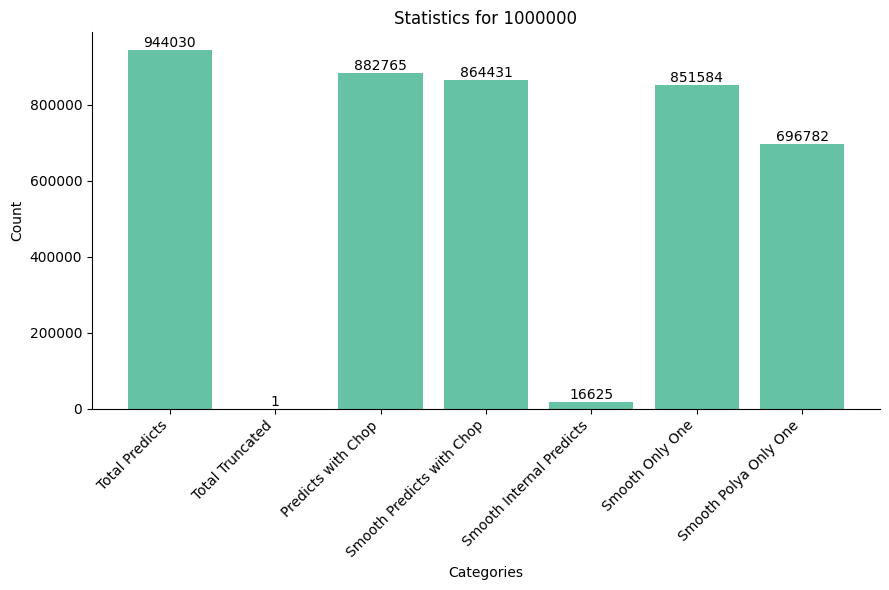

In [20]:
vis_stats(stats, 1000000, (9,6), True)

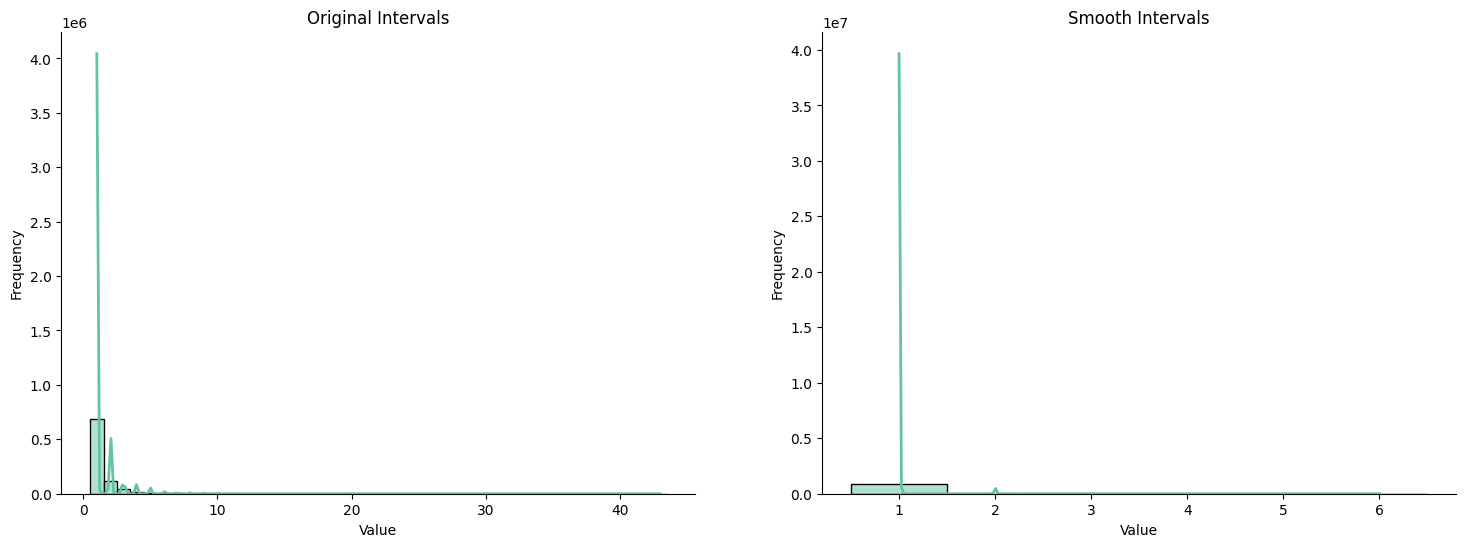

In [21]:
original_prediction_number = stats.number_predicts_with_chop()
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [27]:
def vis_hist_for_num_of_intervals2(data, figsize=(10, 6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1
    if ax is None:
        plt.figure(figsize=figsize)
        sns.kdeplot(data, fill=True, 
                    # common_norm=False, 
                    # palette="crest",
                    # alpha=.5, 
                    # linewidth=0,
                    )
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        sns.kdeplot(data, fill=True, 
                    common_norm=False, 
                    # palette="crest",
                    # alpha=.5, 
                    # linewidth=0,
                    ax=ax
                    )
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

In [ ]:
plot_oregion_size_data = stats.length_predicts_with_chop()
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals2(
    plot_oregion_size_data,
    title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}",
    ax=axs[0],
)
vis_hist_for_num_of_intervals2(
    plot_sregion_size_data,
    title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}",
    ax=axs[1],
)

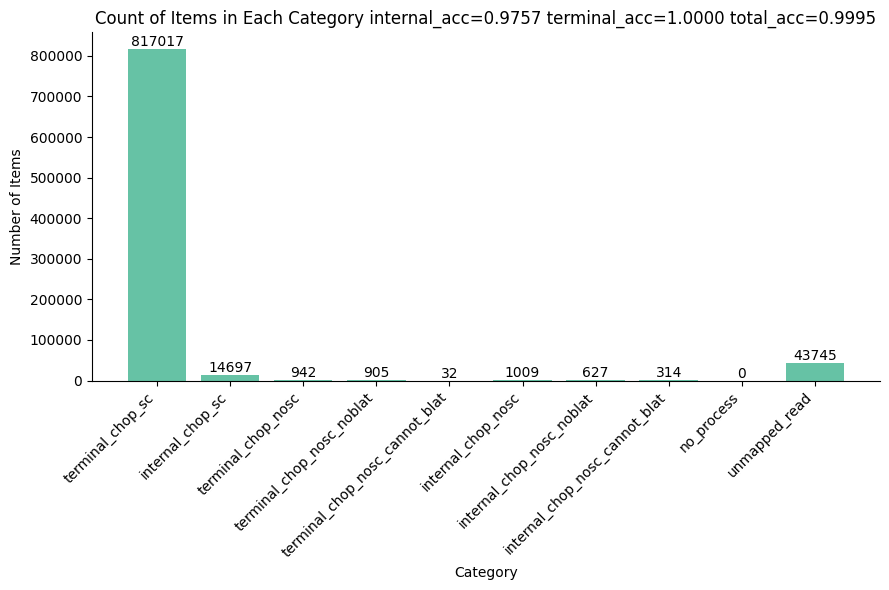

In [12]:
vis_overlap_results(overlap_results)

In [12]:
%%time
rs_sam_records = deepchopper.read_bam_records_parallel(
    "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam"
)

CPU times: user 7min 38s, sys: 1min 4s, total: 8min 42s
Wall time: 1min 1s


In [13]:
%%time
predict_path =   "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"
all_predicts = deepchopper.load_predicts_from_batch_pts(predict_path, -100, None)

Sun Apr 28 23:43:35 2024 INFO Found 31250 pt files


CPU times: user 3min 23s, sys: 38.4 s, total: 4min 2s
Wall time: 55.4 s


In [15]:
def show_predict(pid, rs_sam_records, all_predicts, stats):
    read = rs_sam_records[pid] 
    pd = all_predicts[pid] 
    seq = pd.seq
    deepchopper.utils.highlight_targets(seq, stats.smooth_intervals[pid])

In [17]:
predicts_has_more_than_4 = stats.selected_predict_by_intervals(5)

In [18]:
predicts_has_more_than_4

['69c3f09f-07d9-4919-99db-c8be6db0909a',
 '1620a1ec-fdaf-47d4-8b91-bab6a192625f']

In [22]:
from collections import defaultdict
tmpoop = defaultdict(list)
# pid = 'f9582789-8a72-4676-b6b2-6ef0b7689020'
pids = predicts_has_more_than_4
for pid in pids:
    print(all_predicts[pid].show_info(stats.smooth_intervals[pid]))
    # verify_result_with_sam_records_rs(tmpoop, all_predicts[pid], stats, rs_sam_records[pid])

id: 69c3f09f-07d9-4919-99db-c8be6db0909a
prediction: [159..160, 198..234, 280..286, 287..289, 292..304, 316..397, 399..400, 404..408, 472..481, 482..483, 503..517, 535..541, 542..546, 547..552, 556..561, 563..564]
smooth_intervals: [(198, 234), (284, 304), (316, 402), (503, 517), (537, 558)]
AGAGGAGGAGGAGGAGGAGGAGGAAGAGGAGGAAGAGGAGGAGGAGGAGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAATTGCAGCCTGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGA
GGAGGAGGAAGATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCAGCCCACCTCCCCCCGAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAGGAG
GAGAAAATGAGAAATACCAGTGATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAG
GAAGAGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAGCCTCTTCCCCACCACCTC
CCCAGCCCAGCCCACCACCTCTTCTCTTCTCTTTCCCACCTCCTCCACCACCACCACCAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAATTATTCACCTCTTTCTCTTCTCTTTCCCACCACCA

In [ ]:
# ] softclip: (549, 563), predict: (506, 563), ratio: 0.24561404

In [ ]:
# %%time
# sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [ ]:
# len(sam_records)

In [ ]:
%%time
rs_sam_records = deepchopper.read_bam_records_parallel(
    "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam"
)

In [ ]:
len(rs_sam_records)

In [ ]:
test_chunks = [
    Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
    Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1"),
]

In [ ]:
fq_records = collect_fq_records(
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"
    )
)

In [ ]:
len(fq_records)

In [26]:
## VCaP
hyena_results = [
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"
    ),
    Path(
        "/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"
    ),
]


max_batches = 100
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0], -100, max_batches)

Sun Apr 28 00:20:55 2024 INFO Found 31250 pt files
Sun Apr 28 00:20:55 2024 INFO only load first 100 pt files


In [27]:
len(all_predicts)

3200

In [28]:
%%time
pystats = deepchopper.py_collect_statistics_for_predicts_parallel(
    list(all_predicts.values()),
    smooth_window_size=21,
    min_interval_size=10,
    approved_interval_number=10,
    internal_threshold=INTERNAL_THRESHOLD,
    ploya_threshold=3,
)
stats

CPU times: user 2.04 s, sys: 3.76 ms, total: 2.04 s
Wall time: 36.4 ms


StatResult(total_predicts: 2996,  predicts_with_chop: 2791, smooth_predicts_with_chop: 2743,
                        smooth_internal_predicts: 51, total_truncated: 0, smooth_only_one: 2700,
                        smooth_ploya_only_one: 2202)

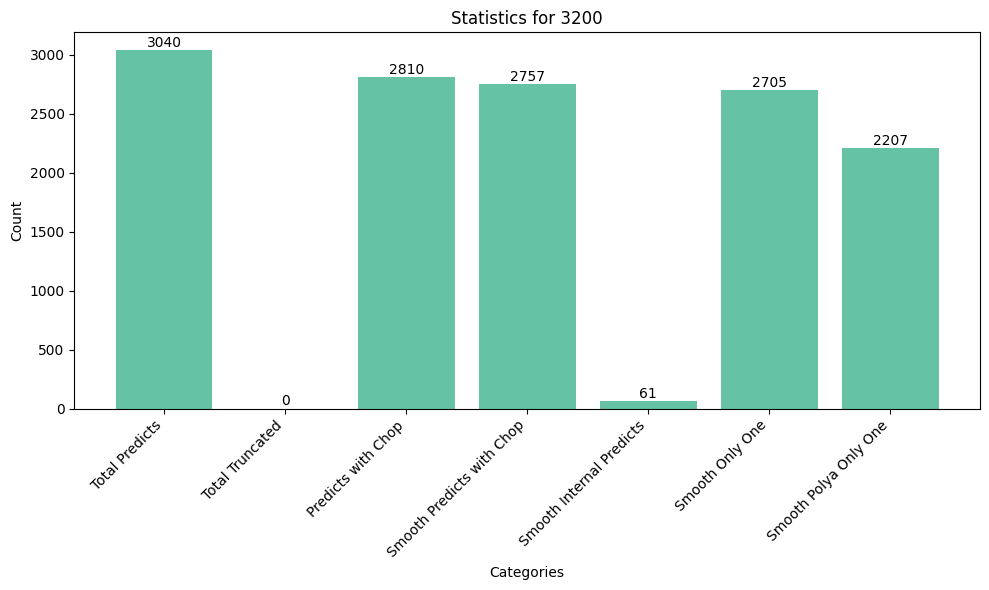

In [29]:
vis_stats(pystats, len(all_predicts))

In [ ]:
print(
    all_predicts[stats.predicts_with_chop[0]].show_info(
        stats.smooth_intervals[stats.predicts_with_chop[0]]
    )
)

In [ ]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [ ]:
len(stats.smooth_only_one_with_ploya)

In [ ]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(
    plot_oregion_size_data,
    title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}",
    ax=axs[0],
)
vis_hist_for_num_of_intervals(
    plot_sregion_size_data,
    title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}",
    ax=axs[1],
)

In [ ]:
total_predicts = len(stats.smooth_predicts_with_chop)
overlap_results = defaultdict(list)
idx = 0

for p in stats.smoo:
    if len(stats.smooth_intervals[p]) >= 3:
        idx += 1
        if idx > 100:
            break

        verify_result_with_sam_records_rs(
            overlap_results, all_predicts[p], stats, rs_sam_records[p]
        )

In [ ]:
vis_overlap_results(overlap_results)

In [ ]:
with open(f"overlap_result_{max_batches}.json", "w") as outfile:
    json.dump(overlap_results, outfile, indent=4, sort_keys=False)

In [ ]:
selected = set(overlap_results["internal_chop_nosc"]) - set(
    overlap_results["internal_chop_nosc_noblat"]
    + overlap_results["internal_chop_nosc_cannot_blat"]
)

for value in selected:
    pd = all_predicts[value]

    verify_result_with_sam_records_rs(
        defaultdict(list),
        pd,
        stats,
        rs_sam_records[value],
        internal_threshold=INTERNAL_THRESHOLD,  # change to 0.9
        overlap_threshold=OVERLAP_THRESHOLD,
        blat_threshold=BLAT_THRESHOLD,
        min_mapping_quality=MIN_MAPPING_QUALITY,
    )

In [ ]:
# %%time
# import json
# from joblib import Parallel, delayed
# # # Run the processing in parallel and collect all results
# results_list = Parallel(n_jobs=1)(
#     delayed(verify_result_with_sam_records_for_parallel)(all_predicts[p].seq,
#                                                          all_predicts[p].id,
#                                                          stats.smooth_intervals,
#                                                          rs_sam_records[p].is_mapped,
#                                                          rs_sam_records[p].mapping_quality ,
#                                                          rs_sam_records[p].left_softclip,
#                                                          rs_sam_records[p].right_softclip,
#                                                          ) for p in stats.smooth_predicts_with_chop)
# overlap_results = merge_results(results_list)

# with open("overlap_result.json", "w") as outfile:
#     json.dump(overlap_results, outfile, indent=4, sort_keys=False)

In [ ]:
for pid, p in all_predicts.items():
    p.qual = fq_records[p.id].qual

In [ ]:
ps = stats.smooth_predicts_with_chop
len(ps)

for p in ps[:1000]:
    pd = all_predicts[p]
    # show_sam_record(pd, stats, sam_records)
    sreg = stats.smooth_intervals.get(p, [])
    if len(sreg) > 2:
        print("\n")
        print(pd.show_info(sreg))

In [ ]:
p = stats.predicts_with_chop[0]
vis_qual_static(
    all_predicts[p], stats.smooth_intervals[p][0][0] - 10, stats.smooth_intervals[p][0][1] + 10
)

In [ ]:
len(stats.smooth_only_one)

In [ ]:
len(stats.smooth_predicts_with_chop)

In [ ]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id]

        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        print(predict.show_info(smooth_regs))

In [ ]:
show_examples(
    set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats
)

In [ ]:
overlap_results.keys()

In [ ]:
# from collections import defaultdict
# ps  = stats.smooth_predicts_with_chop

# overlap_results  = defaultdict(list)
# # ps = set(os) - set(stats.smooth_internal_predicts)
# for p in ps:
#     pd = all_predicts[p]
#     # sreg = stats.smooth_intervals.get(p, [])
#     # if len(sreg) > 2:
#         # show_sam_record(pd, stats, sam_records)
#         # print("\n")
#         # print(pd.show_info(sreg))

#     verify_result_with_sam_records(
#     overlap_results,
#     pd,
#     stats,
#     sam_records,
#     internal_threshold = 0.85,
#     overlap_threshold  = 0.4,
#     blat_threshold  = 0.9,
#     min_mapping_quality = 0)

In [ ]:
stats

In [ ]:
# # overlap_results
# for key, values in overlap_results.items():
#     # if key not in ["internal_chop_sc",  "terminal_chop_sc", "unmap_read",
#     #                # "internal_chop_nosc",
#     #                # "terminal_chop_nosc"
#     #               ]:
#     if (key in ["internal_chop_nosc", "terminal_chop_nosc"]) and (key not in ["internal_chop_nosc_noblat", "terminal_chop_nosc_noblat"]):

#         for value in values:
#             print(f"\n{key}")
#             pd = all_predicts[value]

#             verify_result_with_sam_records_rs(
#             defaultdict(list),
#             pd,
#             stats,
#             rs_sam_records[value],
#             internal_threshold = INTERNAL_THRESHOLD, # change to 0.9
#             overlap_threshold  = OVERLAP_THRESHOLD,
#             blat_threshold  = BLAT_THRESHOLD,
#             min_mapping_quality = MIN_MAPPING_QUALITY)

#             # show_sam_record(pd, stats, sam_records)